In [3]:
import pandas as pd
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable

In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 90.4 MB/s eta 0:00:00:00:0100:01


In [4]:
# Load the dataset
data = pd.read_csv("/kaggle/input/car-sales-report/Car Sales.xlsx - car_data.csv") 

# Preview the first few rows of the dataset
data.head()


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


# **Data Cleaning**

**Preprocess the Data**

****1.Handle missing values:****

* Drop rows or columns with excessive missing data.
* Impute missing values using mean/median for numeric data or mode for categorical data.

**Ensure proper data types:**


* Convert Date to a datetime format.
* Convert categorical columns like Gender, Dealer_Region, Company, and Model to categorical types for better analysis.


In [5]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Fill missing values (example for numeric and categorical columns)
data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].median())
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])

# Ensure categorical data types
categorical_cols = ['Gender', 'Dealer_Region', 'Company', 'Model', 'Color']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Check the cleaned data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Car_id         23906 non-null  object        
 1   Date           23906 non-null  datetime64[ns]
 2   Customer Name  23905 non-null  object        
 3   Gender         23906 non-null  category      
 4   Annual Income  23906 non-null  int64         
 5   Dealer_Name    23906 non-null  object        
 6   Company        23906 non-null  category      
 7   Model          23906 non-null  category      
 8   Engine         23906 non-null  object        
 9   Transmission   23906 non-null  object        
 10  Color          23906 non-null  category      
 11  Price ($)      23906 non-null  int64         
 12  Dealer_No      23906 non-null  object        
 13  Body Style     23906 non-null  object        
 14  Phone          23906 non-null  int64         
 15  Dealer_Region  2390

# Market Analysis
****Evaluate overall trends and regional variations in car sales to assess manufacturer performance, model preferences, and demographic insights.****

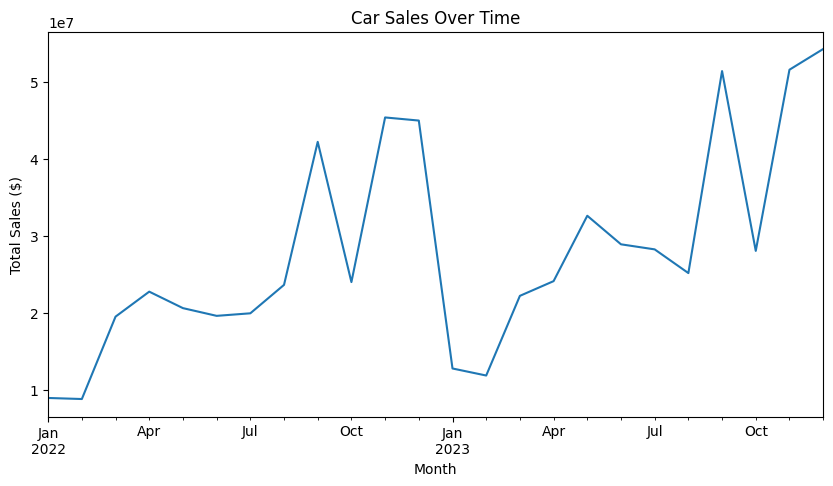

In [7]:
import matplotlib.pyplot as plt

# Group by date and calculate total sales
sales_over_time = data.groupby(data['Date'].dt.to_period('M'))['Price ($)'].sum()

# Plot the results
sales_over_time.plot(kind='line', figsize=(10, 5), title='Car Sales Over Time')
plt.ylabel('Total Sales ($)')
plt.xlabel('Month')
plt.show()


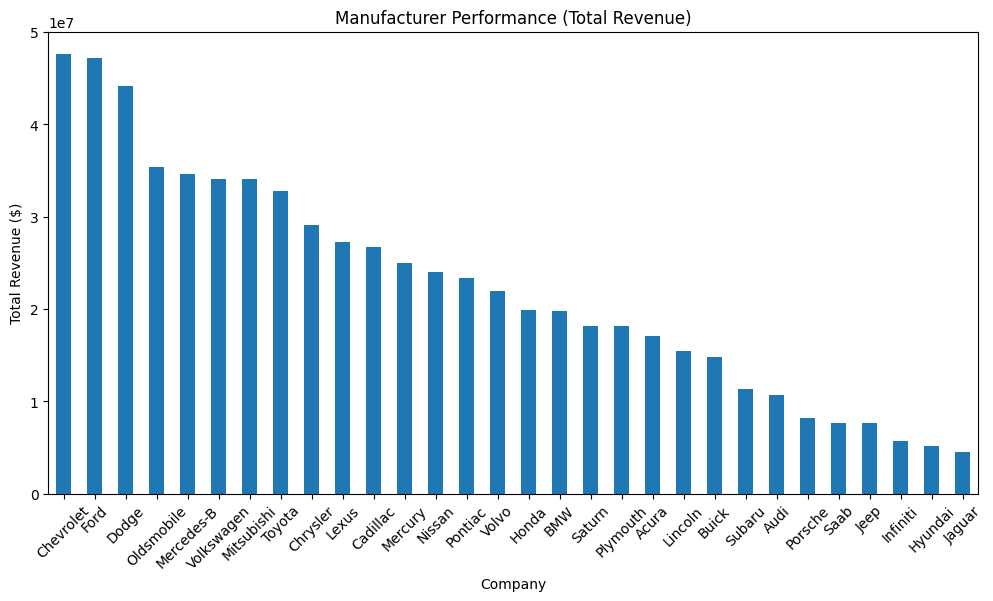

In [8]:
# Group by company and sum revenue
manufacturer_performance = data.groupby('Company', observed=False)['Price ($)'].sum().sort_values(ascending=False)

# Plot the results
manufacturer_performance.plot(kind='bar', figsize=(12, 6), title='Manufacturer Performance (Total Revenue)')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Company')
plt.xticks(rotation=45)
plt.show()


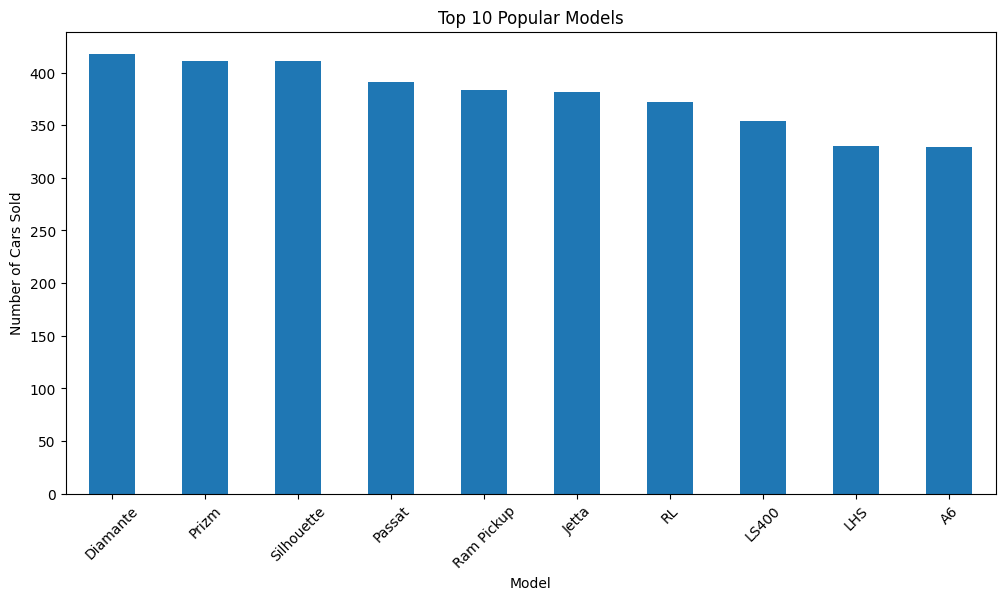

In [9]:
# Group by model and count sales
model_preferences = data['Model'].value_counts().head(10)

# Plot the results
model_preferences.plot(kind='bar', figsize=(12, 6), title='Top 10 Popular Models')
plt.ylabel('Number of Cars Sold')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()


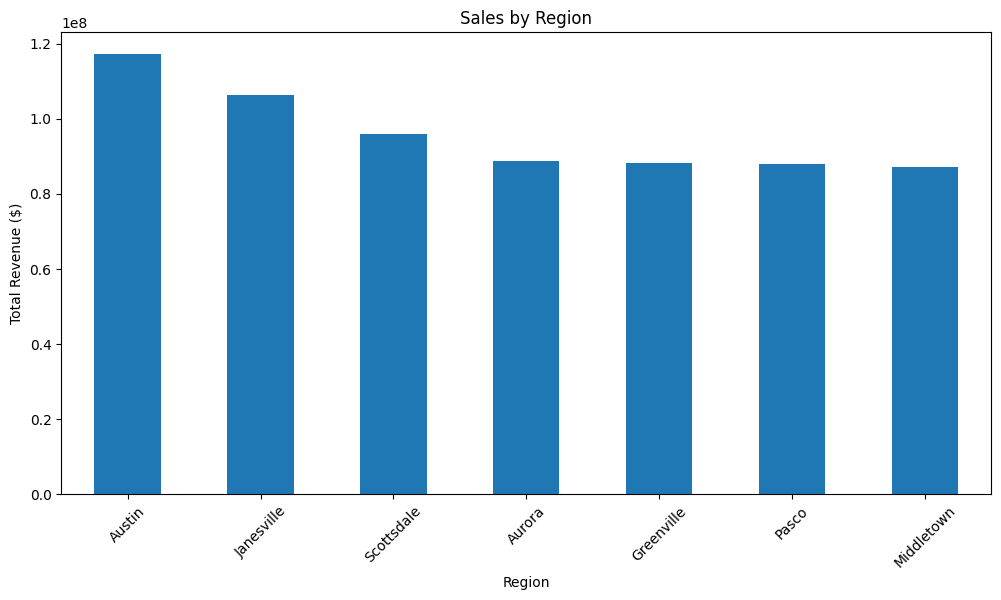

In [10]:
# Group by region and sum revenue
regional_sales = data.groupby('Dealer_Region', observed=False)['Price ($)'].sum().sort_values(ascending=False)

# Plot the results
regional_sales.plot(kind='bar', figsize=(12, 6), title='Sales by Region')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.show()


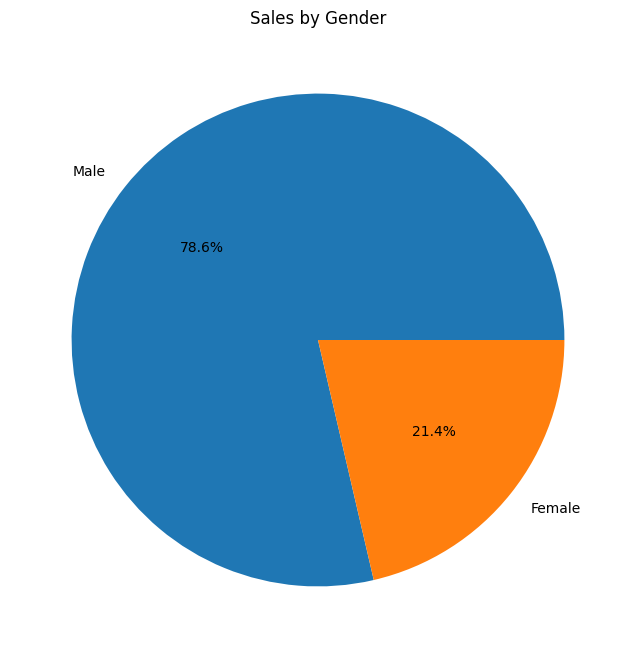

In [11]:
# Group by gender and count sales
gender_sales = data['Gender'].value_counts()

# Plot the results
gender_sales.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='Sales by Gender')
plt.ylabel('')
plt.show()


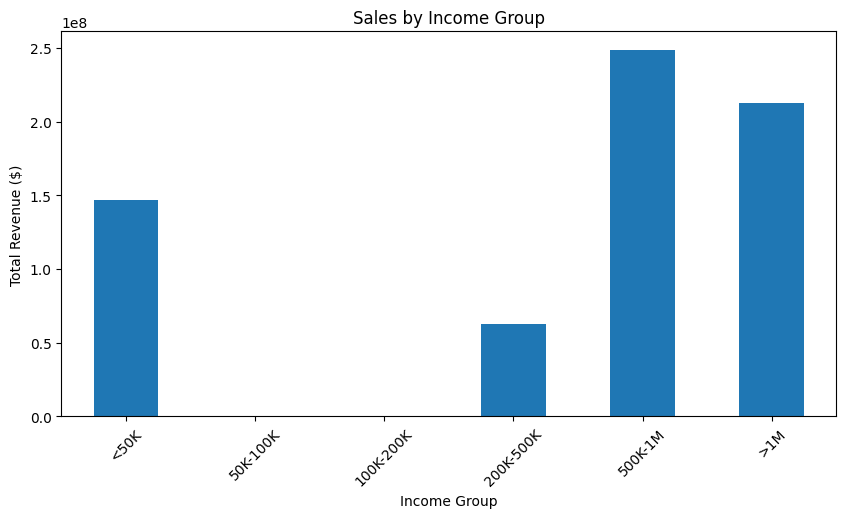

In [12]:
# Define income groups
bins = [0, 50000, 100000, 200000, 500000, 1000000, float('inf')]
labels = ['<50K', '50K-100K', '100K-200K', '200K-500K', '500K-1M', '>1M']
data['Income Group'] = pd.cut(data['Annual Income'], bins=bins, labels=labels)

# Group by income group and count sales
income_group_sales = data.groupby('Income Group', observed=False)['Price ($)'].sum()

# Plot the results
income_group_sales.plot(kind='bar', figsize=(10, 5), title='Sales by Income Group')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Income Group')
plt.xticks(rotation=45)
plt.show()


# Observations
**1. Seasonal Trends:**

* Peak Sales Period: July to October.
* Drop in October: Slight decrease before rising again from October to January.
* Average Sales Period: Remaining months show moderate activity.

**2. Revenue by Manufacturer:**

* Top Performers:Chevrolet leads in revenue generation.
* Ford follows as the second-highest.

**3. Popular Models:**
* Top 10 Models: Diamantte, Shilhoutte, Prizm, Passat, Ram Pickup, Jetta, RL, LS400, LHS, and A6.
  
**4. Sales by Region:**
* Highest Sales: Austin stands out as the region with the most sales.
  
**5. Sales by Gender:**
* Male Buyers Dominate: Male customers form the majority of car purchases.
  
**6. Income Groups:**
* Most Active Buyers: Individuals with an annual income between 500K-1M are the leading purchasers.
